### Coding with Qiskit 1

Before solving this notebook, make sure you have `Qiskit > 1.0` or higher and `Qiskit-ibm-runtime > 0.28` or higher installed. You must use `EstimatorV2` for your solution.

#### Creating the quantum circuit

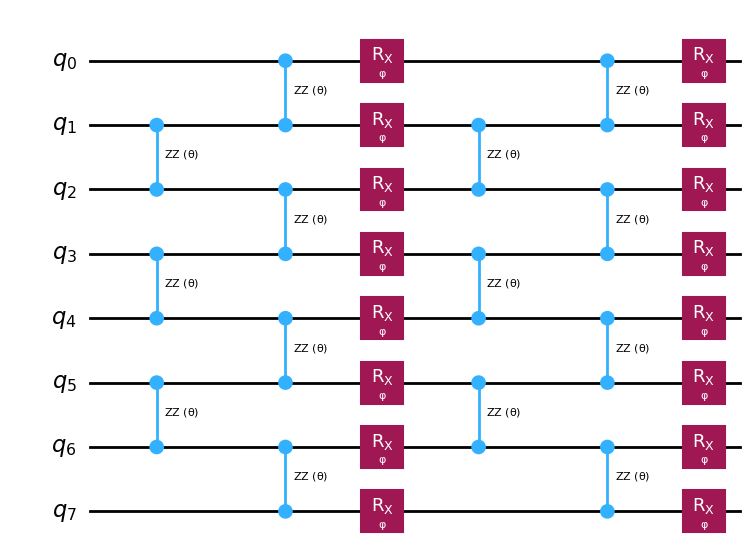

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter('θ')
phi = Parameter('φ')
num_qubits = 8
num_steps = 2

qc = QuantumCircuit(num_qubits)
for _ in range(num_steps):
    for i in range(1, num_qubits-1, 2):
        qc.rzz(theta, i, i+1)
    for i in range(0, num_qubits, 2):
        qc.rzz(theta, i, i+1)
    for i in range(num_qubits):
        qc.rx(phi, i)

qc.draw('mpl', fold=-1)

The goal of this exercise will be to calculate the ideal and noisy expectation values of the specified observables for a range of parameter values. In particular, both $\theta$ and $\phi$ will be varied between $0$ and $\pi$ in 5 equal intervals.

#### Q1. Generate parameters

In this step you need to generate 5 equal interval values between $[0,\pi]$ for each of $\theta$ and $\phi$. Create a copy of the circuit, assign a parameter of your choice, and draw the circuit.

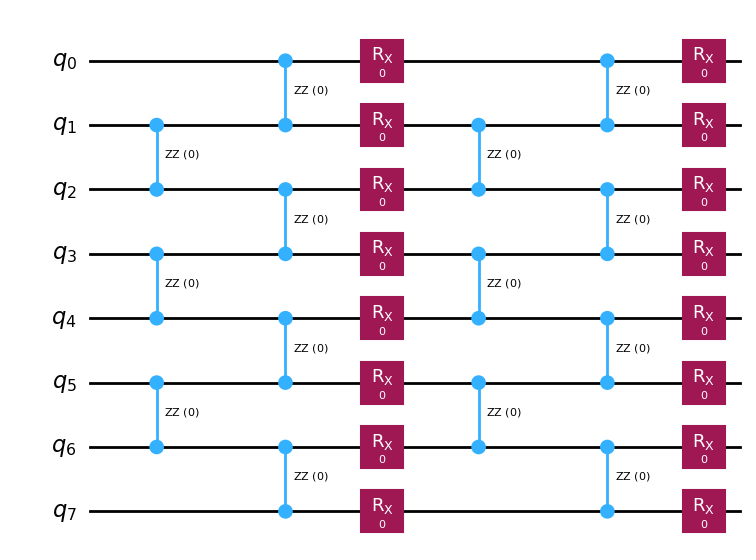

In [2]:
### Your solution here
import math

list_theta = [(math.pi * i)/4 for i in range(5)]
list_phi = [(math.pi * i)/4 for i in range(5)]

list_param = []
for theta in list_theta:
    for phi in list_phi:
        list_param.append([theta, phi])

tmp = qc.assign_parameters({'θ': list_theta[0], 'φ': list_phi[0]}, inplace=False)
tmp.draw('mpl', fold=-1)

#### Q2. Transpile the circuit

In this step you will consider `FakeKolkataV2` as your `backend`. 

- Transpile the circuit on this backend.
- Print the different gates and their counts in the transpiled circuit.
- Print the layout (i.e., the physical qubits on which the circuit is placed) of the transpiled circuit.

[INFO] Gate name and its number in the circuit:
       Gate name: rz, number: 61
       Gate name: sx, number: 32
       Gate name: cx, number: 28
[INFO] Layout of the circuit: physical qubit -> logical qubit
       virtual qubit Qubit(QuantumRegister(8, 'q'), 1) is mapped to physical qubit 25
       virtual qubit Qubit(QuantumRegister(8, 'q'), 2) is mapped to physical qubit 24
       virtual qubit Qubit(QuantumRegister(8, 'q'), 0) is mapped to physical qubit 26
       virtual qubit Qubit(QuantumRegister(8, 'q'), 3) is mapped to physical qubit 23
       virtual qubit Qubit(QuantumRegister(8, 'q'), 4) is mapped to physical qubit 21
       virtual qubit Qubit(QuantumRegister(8, 'q'), 5) is mapped to physical qubit 18
       virtual qubit Qubit(QuantumRegister(8, 'q'), 6) is mapped to physical qubit 15
       virtual qubit Qubit(QuantumRegister(8, 'q'), 7) is mapped to physical qubit 12
[26, 25, 24, 23, 21, 18, 15, 12]


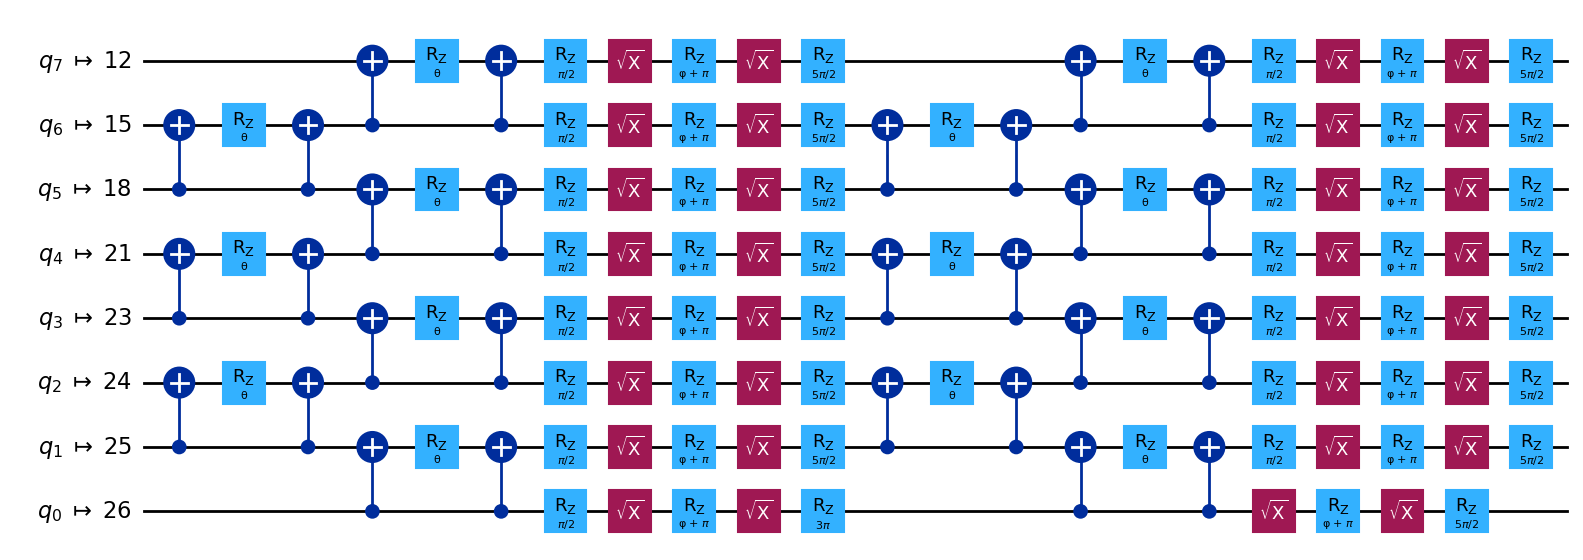

In [11]:
### Your solution here
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeKolkataV2

service = QiskitRuntimeService()

# Get a fake backend from the fake provider
backend = FakeKolkataV2()

# get the default pass manager
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

# compile circuit
transpiled_qc = pass_manager.run(qc)

# print the gates and their number
list_gate_info = transpiled_qc.count_ops()
print("[INFO] Gate name and its number in the circuit:")
for gate_info in list_gate_info:
    print(f"       Gate name: {gate_info}, number: {list_gate_info[gate_info]}")

# print the layout info
layout = transpiled_qc.layout
print("[INFO] Layout of the circuit: physical qubit -> logical qubit")
virtual_to_phyiscal = layout.initial_layout.get_virtual_bits()
for v_qubit in virtual_to_phyiscal:
    if v_qubit._register.name == 'q':    
        print(f"       virtual qubit {v_qubit} is mapped to physical qubit {virtual_to_phyiscal[v_qubit]}")

transpiled_qc.draw('mpl', idle_wires=False)

#### Q3. Construct observable

In this step you will

- Construct the following observable: $\sum_{i=1}^{N}\langle Z_i \rangle / N$ where $N$ is the number of qubits.
- Apply the layout of the transpiled circuit to this observable. Print the observable after applying layout.

In [16]:
### Your solution 
from qiskit.quantum_info import SparsePauliOp

# create pauli
pauli_z = [("Z", [i], 1/num_qubits) for i in range(num_qubits)]
 
# build the operator
hamiltonian = SparsePauliOp.from_sparse_list(
    pauli_z, num_qubits=num_qubits
)

print("[INFO] Observables before apply layout")
print(hamiltonian)
isa_observables = hamiltonian.apply_layout(layout)
print("[INFO] Observables after apply layout")
print(isa_observables)


[INFO] Observables before apply layout
SparsePauliOp(['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'],
              coeffs=[0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j,
 0.125+0.j, 0.125+0.j])
[INFO] Observables after apply layout
SparsePauliOp(['ZIIIIIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIIIII'],
              coeffs=[0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j,
 0.125+0.j, 0.125+0.j])


#### Q4. Prepare for execution

In this step you will create

- Primitive Unified Bloc (PUB) for each possible parameter combination (i.e., there will be $5\times5 = 25$ possible parameter combinations).

In [5]:
### Your solution here

# create PUB
pub_list_wo_noise = []
for p in list_param:
    pub_list_wo_noise.append((qc, [hamiltonian], [p]))

pub_list = []
for p in list_param:
    pub_list.append((transpiled_qc, [isa_observables], [p]))


#### Q5. Noiseless execution

In this step you will

- Construct a `StatevectorEstimator`
- Execute all the PUBs as a **single job**
- Obtain the expectation value for each parameter combination; store the result

In [6]:
### Your solution here

from qiskit.primitives import StatevectorEstimator

# initialize a new statevector simulation based estimator object.
estimator = StatevectorEstimator()

job = estimator.run(pub_list_wo_noise)

sve_result = job.result()

i = 0
noiseless_expectations = []
for theta in list_theta:
    noiseless_expectations.append([])
    for phi in list_phi:
        noiseless_expectations[-1].append(sve_result[i].data.evs[0])
        i += 1
        

#### Q6. Noisy execution

In this step you will

- Construct an `EstimatorV2` object with `FakeKolkataV2` as the backend
- Execute all the PUBs as a **single job**
- Obtain the expectation value for each parameter combination
- In a single plot where X-axis is $\theta$ and Y-axis is $\Phi$, plot the outcomes of the noisy and noiseless expectation values

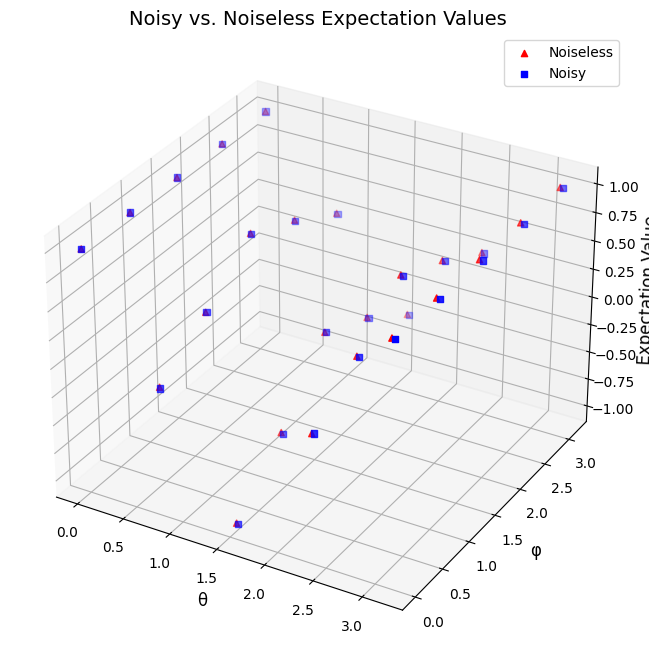

In [10]:
### Your solution here

# from qiskit_aer import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session
from qiskit_aer import AerSimulator

backend = AerSimulator()
# try:
#     with Session(backend=backend) as session:
#         estimator = Estimator(mode=session)
estimator = Estimator(mode=backend)
job = estimator.run(pub_list)
ev_result = job.result()

# noisy_expectations
i = 0
noisy_expectations = []
for theta in list_theta:
    noisy_expectations.append([])
    for phi in list_phi:
        noisy_expectations[-1].append(ev_result[i].data.evs[0])
        i += 1

# plot figure
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

theta, phi = np.meshgrid(list_theta, list_phi)

# Create 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# Plot noiseless values
ax.scatter(theta, phi, noiseless_expectations, c='red', label='Noiseless', marker='^')

# Plot noisy values
for i in range(len(theta)):
    theta[i] *= 1.01
ax.scatter(theta, phi, noisy_expectations, c='blue', label='Noisy', marker='s')

# Add labels and title
ax.set_xlabel('θ', fontsize=12)
ax.set_ylabel('φ', fontsize=12)
ax.set_zlabel('Expectation Value', fontsize=12)
ax.set_title('Noisy vs. Noiseless Expectation Values', fontsize=14)

# Show plot
plt.legend()
plt.show()



#### Q7. Building towards error mitigation

In this step you will create the framework for error mitigation. Obtaining error mitigated results in not possible on a noisy simulator. For this example, we want the following

- Apply Dynamical Decoupling with `XY4` pulse
- Apply Zero Noise Extrapolation with `[1,2,3]` as the noise factors and `exponential` extrapolator
- Turn on Gate Twirling
- Turn off Measurement Twirling
- Turn off Measurement Error Mitigation

Construct an `EstimatorV2` object with the previously stated error mitigation and suppression options.

In [ ]:
### Your solution here
from qiskit_ibm_runtime import EstimatorV2 as Estimator
estimator = Estimator(backend)
options = estimator.options
# Apply Dynamical Decoupling with XY4 pulse
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = 'XY4'
# Apply Zero Noise Extrapolation with [1,2,3] as the noise factors and exponential extrapolator
options.resilience.zne_mitigation = True
options.resilience.zne.noise_factors = [1, 2, 3]
options.resilience.zne.extrapolator = 'exponential'

# Turn on gate twirling.
options.twirling.enable_gates = True
# Turn off measurement twirling.
options.twirling.enable_measure = False
# Turn off measurement error mitigation.
options.resilience.measure_mitigation = False
 